In [50]:
# Import dependencies
import pandas as pd
import numpy as np

from pathlib import Path
from collections import Counter

import matplotlib.pyplot as plt

# Import Data File

In [51]:
# Import data file
county_data_df = pd.read_csv("/content/complete_county_data.csv")

county_data_df.head()

,fips_code,est_hesitant,est_strongly_hesitant,svi,svi_category,cvac,cvac_category,percent_hispanic,percent_american_indian_alaska_native,percent_asian,percent_black,percent_hawaiian_pacific,percent_white,geographical_point,state_code,county_boundary,state_boundary,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,VotingAgeCitizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,percentage20_Donald_Trump,percentage20_Joe_Biden,county_y,state_y,population,density,hesitancy,population_scaled,Winning_candidate_2020
0,1001,0.22,0.10,0.44,Moderate Vulnerability,0.61,High Vulnerability,0.0283,0.0025,0.0103,0.1900,0.0001,0.7460,POINT (-86.844516 32.756889),AL,MULTIPOLYGON (((-86.90309599999999 32.54062599...,"MULTIPOLYGON (((-88.139988 34.581703, -88.1352...",Alabama,Autauga County,55036,26899,28137,2.7,75.4,18.9,0.3,0.9,0.0,41016,55317,2838,27824,2024,13.7,20.1,35.3,18.0,23.2,8.1,15.4,86.0,9.6,0.1,0.6,1.3,2.5,25.8,24112,74.1,20.2,5.6,0.1,5.2,0.715,0.270,Autauga County,AL,55514,urban,moderate hesitancy,5.5514,Trump
1,1003,0.20,0.10,0.22,Low Vulnerability,0.23,Low Vulnerability,0.0456,0.0065,0.0092,0.0917,0.0000,0.8307,POINT (-86.844516 32.756889),AL,"MULTIPOLYGON (((-87.990684 30.55549, -87.98783...","MULTIPOLYGON (((-88.139988 34.581703, -88.1352...",Alabama,Baldwin County,203360,99527,103833,4.4,83.1,9.5,0.8,0.7,0.0,155376,52562,1348,29364,735,11.8,16.1,35.7,18.2,25.6,9.7,10.8,84.7,7.6,0.1,0.8,1.1,5.6,27.0,89527,80.7,12.9,6.3,0.1,5.5,0.762,0.223,Baldwin County,AL,190790,urban,moderate hesitancy,19.0790,Trump
2,1005,0.23,0.11,1.00,Very High Vulnerability,0.89,Very High Vulnerability,0.0436,0.0029,0.0048,0.4744,0.0000,0.4581,POINT (-86.844516 32.756889),AL,"MULTIPOLYGON (((-85.429819 32.045983, -85.4303...","MULTIPOLYGON (((-88.139988 34.581703, -88.1352...",Alabama,Barbour County,26201,13976,12225,4.2,45.7,47.8,0.2,0.6,0.0,20269,33368,2551,17561,798,27.2,44.9,25.0,16.8,22.6,11.5,24.1,83.4,11.1,0.3,2.2,1.7,1.3,23.4,8878,74.1,19.1,6.5,0.3,12.4,0.536,0.456,Barbour County,AL,27201,rural,moderate hesitancy,2.7201,Trump
3,1007,0.24,0.12,0.60,High Vulnerability,0.76,High Vulnerability,0.0257,0.0013,0.0012,0.2214,0.0000,0.7453,POINT (-86.844516 32.756889),AL,"MULTIPOLYGON (((-87.312265 33.086219, -87.3121...","MULTIPOLYGON (((-88.139988 34.581703, -88.1352...",Alabama,Bibb County,22580,12251,10329,2.4,74.6,22.0,0.4,0.0,0.0,17662,43404,3431,20911,1889,15.2,26.6,24.4,17.6,19.7,15.9,22.4,86.4,9.5,0.7,0.3,1.7,1.5,30.0,8171,76.0,17.4,6.3,0.3,8.2,0.784,0.207,Bibb County,AL,22597,urban,moderate hesitancy,2.2597,Trump
4,1009,0.23,0.11,0.42,Moderate Vulnerability,0.80,High Vulnerability,0.0926,0.0007,0.0037,0.0153,0.0004,0.8689,POINT (-86.844516 32.756889),AL,"MULTIPOLYGON (((-86.74918799999999 33.997596, ...","MULTIPOLYGON (((-88.139988 34.581703, -88.1352...",Alabama,Blount County,57667,28490,29177,9.0,87.4,1.5,0.3,0.1,0.0,42513,47412,2630,22021,850,15.6,25.4,28.5,12.9,23.3,15.8,19.5,86.8,10.2,0.1,0.4,0.4,2.1,35.0,21380,83.9,11.9,4.0,0.1,4.9,0.896,0.096,Blount County,AL,57826,urban,moderate hesitancy,5.7826,Trump


In [52]:
filtered_county_data_df = county_data_df.drop(columns={"svi_category", "cvac", "cvac_category", "svi", "est_strongly_hesitant", "est_hesitant", "geographical_point", "state_code", "county_boundary", "state_boundary", "State", "County"})
filtered_county_data_df.head()

,fips_code,percent_hispanic,percent_american_indian_alaska_native,percent_asian,percent_black,percent_hawaiian_pacific,percent_white,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,VotingAgeCitizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,percentage20_Donald_Trump,percentage20_Joe_Biden,county_y,state_y,population,density,hesitancy,population_scaled,Winning_candidate_2020
0,1001,0.0283,0.0025,0.0103,0.1900,0.0001,0.7460,55036,26899,28137,2.7,75.4,18.9,0.3,0.9,0.0,41016,55317,2838,27824,2024,13.7,20.1,35.3,18.0,23.2,8.1,15.4,86.0,9.6,0.1,0.6,1.3,2.5,25.8,24112,74.1,20.2,5.6,0.1,5.2,0.715,0.270,Autauga County,AL,55514,urban,moderate hesitancy,5.5514,Trump
1,1003,0.0456,0.0065,0.0092,0.0917,0.0000,0.8307,203360,99527,103833,4.4,83.1,9.5,0.8,0.7,0.0,155376,52562,1348,29364,735,11.8,16.1,35.7,18.2,25.6,9.7,10.8,84.7,7.6,0.1,0.8,1.1,5.6,27.0,89527,80.7,12.9,6.3,0.1,5.5,0.762,0.223,Baldwin County,AL,190790,urban,moderate hesitancy,19.0790,Trump
2,1005,0.0436,0.0029,0.0048,0.4744,0.0000,0.4581,26201,13976,12225,4.2,45.7,47.8,0.2,0.6,0.0,20269,33368,2551,17561,798,27.2,44.9,25.0,16.8,22.6,11.5,24.1,83.4,11.1,0.3,2.2,1.7,1.3,23.4,8878,74.1,19.1,6.5,0.3,12.4,0.536,0.456,Barbour County,AL,27201,rural,moderate hesitancy,2.7201,Trump
3,1007,0.0257,0.0013,0.0012,0.2214,0.0000,0.7453,22580,12251,10329,2.4,74.6,22.0,0.4,0.0,0.0,17662,43404,3431,20911,1889,15.2,26.6,24.4,17.6,19.7,15.9,22.4,86.4,9.5,0.7,0.3,1.7,1.5,30.0,8171,76.0,17.4,6.3,0.3,8.2,0.784,0.207,Bibb County,AL,22597,urban,moderate hesitancy,2.2597,Trump
4,1009,0.0926,0.0007,0.0037,0.0153,0.0004,0.8689,57667,28490,29177,9.0,87.4,1.5,0.3,0.1,0.0,42513,47412,2630,22021,850,15.6,25.4,28.5,12.9,23.3,15.8,19.5,86.8,10.2,0.1,0.4,0.4,2.1,35.0,21380,83.9,11.9,4.0,0.1,4.9,0.896,0.096,Blount County,AL,57826,urban,moderate hesitancy,5.7826,Trump


# Split the Data into Training and Testing

In [53]:
# Choose Independent variables
X = county_data_df[["percent_white","percent_hispanic", "percent_american_indian_alaska_native",
                        "percent_asian", "percent_black", "percent_hawaiian_pacific", "Poverty", 
                        "ChildPoverty", "Drive","Carpool", "Transit", "Walk", "OtherTransp",
                        "WorkAtHome", "PrivateWork", "PublicWork", "SelfEmployed", "FamilyWork", "Unemployment", 
                        "percentage20_Donald_Trump", "percentage20_Joe_Biden", "population_scaled"]]

# Create our target
y = county_data_df['hesitancy']

X.describe()

,percent_white,percent_hispanic,percent_american_indian_alaska_native,percent_asian,percent_black,percent_hawaiian_pacific,Poverty,ChildPoverty,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,percentage20_Donald_Trump,percentage20_Joe_Biden,population_scaled
count,3075.000000,3075.000000,3075.000000,3075.000000,3075.000000,3075.000000,3075.000000,3075.000000,3075.000000,3075.000000,3075.000000,3075.000000,3075.000000,3075.000000,3075.000000,3075.000000,3075.000000,3075.000000,3075.000000,3075.000000,3075.000000,3075.000000
mean,0.765595,0.094774,0.015703,0.013121,0.089487,0.000797,16.016878,22.153821,79.857333,9.895642,0.909626,3.018959,1.521854,4.798081,75.203187,16.743545,7.771089,0.283447,6.326407,0.653608,0.329154,9.977227
std,0.199056,0.139029,0.065532,0.026105,0.144267,0.003888,6.547258,10.308046,6.661486,2.901009,3.003669,2.875258,1.141899,3.088986,7.343466,5.963499,3.875747,0.453048,2.992911,0.159027,0.157901,32.134315
min,0.006900,0.000000,0.000000,0.000000,0.000000,0.000000,2.400000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31.100000,4.400000,0.000000,0.000000,0.000000,0.088000,0.031000,0.007100
25%,0.648300,0.022200,0.001200,0.002800,0.006450,0.000000,11.400000,14.900000,77.400000,8.100000,0.100000,1.400000,0.800000,2.900000,71.800000,12.600000,5.200000,0.100000,4.400000,0.565000,0.208000,1.115350
50%,0.838500,0.042400,0.002800,0.006100,0.022000,0.000100,15.200000,21.200000,81.000000,9.500000,0.300000,2.200000,1.300000,4.100000,76.300000,15.700000,6.800000,0.200000,6.000000,0.686000,0.297000,2.581500
75%,0.925200,0.097950,0.006600,0.012600,0.099450,0.000600,19.450000,27.800000,84.000000,11.300000,0.700000,3.800000,1.900000,5.800000,80.300000,19.400000,9.200000,0.300000,7.800000,0.775500,0.418000,6.660800
max,1.000000,0.991700,0.901900,0.417300,0.872300,0.110800,52.000000,76.500000,97.200000,29.300000,61.800000,42.400000,13.800000,33.000000,88.800000,64.800000,38.000000,8.000000,28.700000,0.962000,0.896000,996.278900


In [54]:
from sklearn.model_selection import train_test_split

# Data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

# Fit scaler on training data
#norm = MinMaxScaler().fit(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
min_max_scaler = MinMaxScaler()
X_train_scaled = min_max_scaler.fit_transform(X_train)
X_test_scaled = min_max_scaler.fit_transform(X_test)

print(Counter(y_train))
print(Counter(y_test))

Counter({'moderate hesitancy': 1641, 'low hesitancy': 380, 'high hesitancy': 285})
Counter({'moderate hesitancy': 558, 'low hesitancy': 119, 'high hesitancy': 92})


# Logistic Regression Model

In [55]:
# Import regression model
from sklearn.linear_model import LogisticRegression

# Instantiate the model (using the default parameters)
logreg = LogisticRegression(solver='saga', random_state=1)

# Fit the model with data
logreg.fit(X_train_scaled, y_train)

y_pred = logreg.predict(X_test_scaled)

print(y_pred.shape)

(769,)


In [56]:
# Print coefficients
print(logreg.coef_)

[[-1.46116916 -2.71613215  2.3557057  -0.82048813  3.44350512  0.12201343
   2.40099358  0.21221037 -0.25618851 -0.03447955 -0.20576052  1.06750116
   0.36998106 -0.48515967 -0.7451212  -0.04763786  1.04031555  0.82378446
  -0.78715138  2.08258652 -2.66222262 -0.37468956]
 [ 0.85540673  1.27813883 -0.72966382  1.87757294 -3.0443312   0.5887336
  -3.24053367 -0.83468015 -0.53588843  0.14563458  1.06780697 -1.43757283
  -0.52564742  1.26891504 -0.0067022   0.6164534  -0.81629471 -0.82744478
  -0.06506592 -2.92425815  2.61269498  0.03250821]
 [ 0.60576242  1.43799332 -1.62604188 -1.05708482 -0.39917392 -0.71074703
   0.83954008  0.62246978  0.79207693 -0.11115503 -0.86204645  0.37007167
   0.15566636 -0.78375537  0.7518234  -0.56881553 -0.22402084  0.00366031
   0.8522173   0.84167163  0.04952764  0.34218135]]


In [57]:
# Print intercept values
print(logreg.intercept_)

[-0.26469261  1.3820545  -1.11736189]


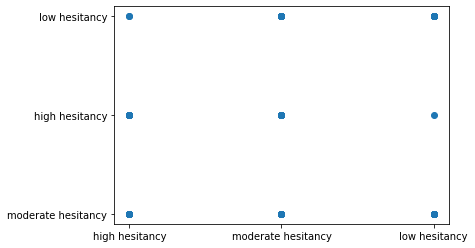

In [58]:
# Test model with predictions
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(y_test, y_pred)

In [59]:
# Import the metrics class
from sklearn import metrics
cnf1 = metrics.confusion_matrix(y_test, y_pred, labels=["low hesitancy", "moderate hesitancy", "high hesitancy"])
cnf1

array([[ 46,  72,   1],
       [ 13, 530,  15],
       [  2,  72,  18]])

In [60]:
# Create a DataFrame from the confusion matrix.
cnf1_df = pd.DataFrame(
    cnf1, index=["Actual Low", "Actual Medium", "Actual High"], columns=["Predicted Low", "Predicted Medium", "Predicted High"])

cnf1_df

,Predicted Low,Predicted Medium,Predicted High
Actual Low,46,72,1
Actual Medium,13,530,15
Actual High,2,72,18


In [61]:
# Print accuracy, precision, recall
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

print("Precision:",metrics.precision_score(y_test, y_pred,
                                          average='micro'))

print("Recall:",metrics.recall_score(y_test, y_pred, 
                                     average='micro'))

Accuracy: 0.7724317295188556
Precision: 0.7724317295188556
Recall: 0.7724317295188556


In [62]:
# Print classification 
from imblearn.metrics import classification_report_imbalanced
print(metrics.classification_report(y_test, y_pred))

print(classification_report_imbalanced(y_test, y_pred))

                    precision    recall  f1-score   support

    high hesitancy       0.53      0.20      0.29        92
     low hesitancy       0.75      0.39      0.51       119
moderate hesitancy       0.79      0.95      0.86       558

          accuracy                           0.77       769
         macro avg       0.69      0.51      0.55       769
      weighted avg       0.75      0.77      0.74       769

                          pre       rec       spe        f1       geo       iba       sup

    high hesitancy       0.53      0.20      0.98      0.29      0.44      0.18        92
     low hesitancy       0.75      0.39      0.98      0.51      0.61      0.36       119
moderate hesitancy       0.79      0.95      0.32      0.86      0.55      0.32       558

       avg / total       0.75      0.77      0.50      0.74      0.55      0.31       769



In [63]:
np.round(logreg.coef_,decimals=2) > 0
X.columns

Index(['percent_white', 'percent_hispanic',
       'percent_american_indian_alaska_native', 'percent_asian',
       'percent_black', 'percent_hawaiian_pacific', 'Poverty', 'ChildPoverty',
       'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp', 'WorkAtHome',
       'PrivateWork', 'PublicWork', 'SelfEmployed', 'FamilyWork',
       'Unemployment', 'percentage20_Donald_Trump', 'percentage20_Joe_Biden',
       'population_scaled'],
      dtype='object')

In [64]:
from sklearn.feature_selection import RFE
predictors = X_train_scaled
selector = RFE(logreg, n_features_to_select = 1)
selector = selector.fit(predictors, y_train)
order = selector.ranking_
print(order)
feature_ranks = []
for index, ranking in enumerate(order):
  feature_ranks.append(f"{ranking}. {X.columns[index]}")
  #print(f"{ranking}. {X.columns[index]}")

feature_ranks

[10  9  4  6  3 18  1 16 17 22 12  7 20  8 13 19 11 14 15  5  2 21]


['10. percent_white',
 '9. percent_hispanic',
 '4. percent_american_indian_alaska_native',
 '6. percent_asian',
 '3. percent_black',
 '18. percent_hawaiian_pacific',
 '1. Poverty',
 '16. ChildPoverty',
 '17. Drive',
 '22. Carpool',
 '12. Transit',
 '7. Walk',
 '20. OtherTransp',
 '8. WorkAtHome',
 '13. PrivateWork',
 '19. PublicWork',
 '11. SelfEmployed',
 '14. FamilyWork',
 '15. Unemployment',
 '5. percentage20_Donald_Trump',
 '2. percentage20_Joe_Biden',
 '21. population_scaled']

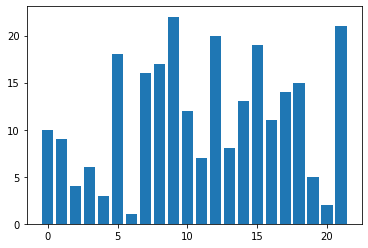

In [65]:
plt.bar([x for x in range(len(order))], order)
plt.show()

# Oversampling

### Naive Random Oversampling

In [66]:
# Resample the training data with the RandomOversampler
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({'high hesitancy': 1641,
         'low hesitancy': 1641,
         'moderate hesitancy': 1641})

In [67]:
# Train the Logistic Regression model using the resampled data
#from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='saga', random_state=1)
model.fit(X_resampled, y_resampled)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(random_state=1, solver='saga')

In [68]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test, y_pred)

0.5106758614307497

In [69]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[ 61,  15,  16],
       [ 14,  75,  30],
       [188, 110, 260]])

In [70]:
# Print the imbalanced classification report
#from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred))

                          pre       rec       spe        f1       geo       iba       sup

    high hesitancy       0.23      0.66      0.70      0.34      0.68      0.46        92
     low hesitancy       0.38      0.63      0.81      0.47      0.71      0.50       119
moderate hesitancy       0.85      0.47      0.78      0.60      0.60      0.35       558

       avg / total       0.70      0.51      0.78      0.55      0.63      0.39       769



### SMOTE Oversampling

In [71]:
# Resample the training data with SMOTE
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE(random_state=1,
sampling_strategy='auto').fit_resample(
   X_train, y_train)
Counter(y_resampled)

Counter({'high hesitancy': 1641,
         'low hesitancy': 1641,
         'moderate hesitancy': 1641})

In [72]:
# Train the Logistic Regression model using the resampled data
model = LogisticRegression(solver='saga', random_state=1)
model.fit(X_resampled, y_resampled)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(random_state=1, solver='saga')

In [73]:
# Calculated the balanced accuracy score
y_pred = model.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.5836541722813483

In [74]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[ 61,  15,  16],
       [ 14,  77,  28],
       [195, 117, 246]])

In [75]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                          pre       rec       spe        f1       geo       iba       sup

    high hesitancy       0.23      0.66      0.69      0.34      0.68      0.46        92
     low hesitancy       0.37      0.65      0.80      0.47      0.72      0.51       119
moderate hesitancy       0.85      0.44      0.79      0.58      0.59      0.34       558

       avg / total       0.70      0.50      0.78      0.53      0.62      0.38       769



# Undersampling

In [76]:
# Resample the data using the ClusterCentroids resampler
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state=1)
X_resampled, y_resampled = cc.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({'high hesitancy': 285,
         'low hesitancy': 285,
         'moderate hesitancy': 285})

In [77]:
# Train the Logistic Regression model using the resampled data
#from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='saga', random_state=1)
model.fit(X_resampled, y_resampled)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(random_state=1, solver='saga')

In [78]:
# Calculated the balanced accuracy score
#from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test, y_pred)

0.5836541722813483

In [79]:
# Display the confusion matrix
#from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[ 70,  11,  11],
       [ 19,  79,  21],
       [319, 172,  67]])

In [80]:
# Print the imbalanced classification report
#from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred))

                          pre       rec       spe        f1       geo       iba       sup

    high hesitancy       0.17      0.76      0.50      0.28      0.62      0.39        92
     low hesitancy       0.30      0.66      0.72      0.41      0.69      0.47       119
moderate hesitancy       0.68      0.12      0.85      0.20      0.32      0.09       558

       avg / total       0.56      0.28      0.79      0.25      0.41      0.19       769



# Combination (Over and Under) Sampling

In [81]:
# Resample the training data with SMOTEENN
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)
Counter(y_resampled)

Counter({'high hesitancy': 2063,
         'low hesitancy': 2034,
         'moderate hesitancy': 826})

In [82]:
# Train the Logistic Regression model using the resampled data
#from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='saga', random_state=1)
model.fit(X_resampled, y_resampled)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(random_state=1, solver='saga')

In [83]:
# Calculated the balanced accuracy score
#from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test, y_pred)

0.5149355986745642

In [84]:
# Display the confusion matrix
#from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[ 72,  17,   3],
       [ 17,  99,   3],
       [314, 178,  66]])

In [85]:
# Print the imbalanced classification report
#from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred))

                          pre       rec       spe        f1       geo       iba       sup

    high hesitancy       0.18      0.78      0.51      0.29      0.63      0.41        92
     low hesitancy       0.34      0.83      0.70      0.48      0.76      0.59       119
moderate hesitancy       0.92      0.12      0.97      0.21      0.34      0.11       558

       avg / total       0.74      0.31      0.87      0.26      0.44      0.22       769



# Balanced Random Forest Classifier

In [86]:
np.random.seed(42)
#Specific to Google Collab to ensure the BalancedRandomForestClassifier is working
#!pip install -Iv imblearn==0.0

In [87]:
# Resample the training data with the BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
brf_model = BalancedRandomForestClassifier(n_estimators=100, criterion = "entropy", bootstrap = True, random_state=42) 
brf_model.fit(X_train, y_train)

BalancedRandomForestClassifier(criterion='entropy', random_state=42)

In [88]:
# Calculated the balanced accuracy score
y_prediction = brf_model.predict(X_test)
balanced_accuracy_score(y_test, y_prediction)

0.7194386715259581

In [89]:
# Display the confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred, labels=["low hesitancy", "moderate hesitancy", "high hesitancy"])
print(cm)
# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual Low", "Actual Medium", "Actual High"], columns=["Predicted Low", "Predicted Medium", "Predicted High"])

cm_df

[[ 99   3  17]
 [178  66 314]
 [ 17   3  72]]


,Predicted Low,Predicted Medium,Predicted High
Actual Low,99,3,17
Actual Medium,178,66,314
Actual High,17,3,72


In [90]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_prediction))

                          pre       rec       spe        f1       geo       iba       sup

    high hesitancy       0.35      0.75      0.81      0.48      0.78      0.61        92
     low hesitancy       0.46      0.82      0.82      0.59      0.82      0.67       119
moderate hesitancy       0.91      0.59      0.85      0.72      0.71      0.49       558

       avg / total       0.78      0.65      0.84      0.67      0.74      0.53       769



In [91]:
features_ranked = sorted(zip(brf_model.feature_importances_, X.columns), reverse=True)
for feature in features_ranked:
  print(f"{feature[1]}: ({feature[0]})")

percentage20_Joe_Biden: (0.07449790726840502)
Poverty: (0.07258997373823836)
ChildPoverty: (0.06682124686426658)
percent_black: (0.06682037975756513)
percentage20_Donald_Trump: (0.06484673290834526)
WorkAtHome: (0.060070676092511974)
Transit: (0.057468654527936626)
percent_asian: (0.05700446480989741)
population_scaled: (0.0553052376809115)
Unemployment: (0.04266909481643594)
percent_white: (0.04232369233498349)
percent_hispanic: (0.041528620997052595)
Drive: (0.04121866633762804)
percent_american_indian_alaska_native: (0.04011794736637077)
PrivateWork: (0.03596472838381788)
PublicWork: (0.03218509194651056)
Walk: (0.0300431112816284)
SelfEmployed: (0.029625559049406777)
Carpool: (0.029007839765002204)
OtherTransp: (0.024616502560999915)
FamilyWork: (0.017941957946933512)
percent_hawaiian_pacific: (0.01733191356515197)


# Easy Ensemble AdaBoost Classifier

In [92]:
# Train the EasyEnsembleClassifier
from imblearn.ensemble import EasyEnsembleClassifier
eec = EasyEnsembleClassifier(n_estimators=100, random_state=1)
eec.fit(X_train, y_train)

EasyEnsembleClassifier(n_estimators=100, random_state=1)

In [93]:
# Calculated the balanced accuracy score
y_predict_eec = eec.predict(X_test)
balanced_accuracy_score(y_test, y_predict_eec)

0.6770162327047072

In [94]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_predict_eec))

                          pre       rec       spe        f1       geo       iba       sup

    high hesitancy       0.31      0.70      0.79      0.43      0.74      0.54        92
     low hesitancy       0.42      0.81      0.80      0.56      0.80      0.65       119
moderate hesitancy       0.88      0.53      0.81      0.66      0.65      0.42       558

       avg / total       0.74      0.59      0.81      0.62      0.69      0.47       769



# Random Forest Classifier

In [95]:
# Fitting Random Forest Regression to the dataset
# import the Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

In [96]:
# create regressor object
RF = RandomForestClassifier(n_estimators = 100, criterion = "gini", random_state = 42)
RF.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [97]:
# Calculated the balanced accuracy score
y_prediction = RF.predict(X_test)
balanced_accuracy_score(y_test, y_prediction)

0.5876920504838994

In [98]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_prediction))

                          pre       rec       spe        f1       geo       iba       sup

    high hesitancy       0.62      0.28      0.98      0.39      0.53      0.26        92
     low hesitancy       0.76      0.54      0.97      0.63      0.72      0.50       119
moderate hesitancy       0.82      0.94      0.45      0.88      0.65      0.44       558

       avg / total       0.79      0.80      0.59      0.78      0.64      0.43       769

